# Фильтр Калмана

In [1]:
import numpy as np

import yfinance as yf #эх........

import matplotlib.pyplot as plt
import scipy.interpolate as spint
%matplotlib inline

Фильтр Калмана -- популярная процедура для решения задачи прогноза, фильтрации и сглаживания во временных рядах. В этом семинаре мы изучим, как строится работает фильтра Калмана в дискретном времени, а также поговорим об оценке параметров с помощью ЕМ-алгоритма.

В центре нашенго внимания будет линейная модель мира и наблюдений вида

$$
\begin{align*}
&Y_{t+1} = F Y_t + U_t,\\
&X_{t} = G Y_{t} + V_t,\\
\end{align*}
$$

с матрицами $F \in \mathbb{R}^{n \times n}, X \in \mathbb{R}^{m \times n}$ и гауссовскими процессами белого шума $U_t \sim N(0, Q)$, $V_t \sim N(0, R)$. Как и раньше, $X$ -- процесс наблюдений (они у нас есть), а $Y$ -- процесс реального мира, который мы не наблюдаем; при этом размерность наблюдений может быть меньше или больше, чем размерность реальных состояний.

## Фильтр Калмана в дискретном времени

### Фильтрация

Рассмотрим фильтр Калмана для дискретного времени и предположим, что параметры модели, то есть, $F,G,Q,R$ известны. Мы пока строим решение для задачи фильтрации, то есть, предсказания $Y_t$ на основе наблюдений $X_t$. В его основе лежит идея, что новое отфильтрованное значение можно получать как предыдущее, скорректированное на невязку прогноза с предыдущего шага. Показано, что данный фильтр оптимален (лучше нет) в случае гауссовского шума, а в случае негауссовского с конечным вторым моментом оптимален среди линейных оценок.

Заметка о выводе на доске....

В итоге для процедуры фильтрации получаем итерационную схему. Если даны наблюдения $X_1,..,X_T$ для $t=1,..,T$, то фильтрация $Y$ на основе предыдущей истории выглядит так:

$$
\begin{aligned}
&\tilde{Y}_t = F \hat{Y}_{t-1},\\
&\tilde{P}_t = F P_{t-1}F^T + Q,\\
&K_t = \tilde{P}_t G^T (G\tilde{P}_tG^T + R)^{-1},\\
&\hat{Y}_t = \tilde{Y}_t + K_t(X_t - G \tilde{Y}_t)\\
&P_t = (I- K_tG)\tilde{P}_t(I- K_tG)^T + K_tRK_t^T.
\end{aligned}
$$

Эта схема выглядит немного сложно, но у неё вполне продуманная идея:
1. $\tilde{Y}_t$ -- это априорный прогноз, полученный с предыдущего шага, когда ещё не было наблюдения. В условиях известной модели это вполне полезная информация.
2. $\tilde{P}_t$ -- это ковариационная матрица ошибки априорного прогноза (фильтр Калмана выдаёт несмещённые оценки, но это тема для отдельной дискуссии), которая тоже даёт дополнительную информацию о неопределённости априорного прогноза $\tilde{Y}_t$.
3. $K_t$ -- это фильтр, Kalman gain, который используется для того, чтобы использовать невязку априорного прогноза для коррекции априорного прогноза и получения $\hat{Y}_t$.
4. $P_t$ -- это ковариационная матрица апостериорной ошибки $e_t = \hat{Y}_t - Y_t$.

То есть, мы делаем прогноз на будущее, ждём новые данные и с их учётом корректируем прогноз по пути отслеживая уровень неопределённости с помощью $P_t$.

### Предсказание

Имея параметры, в качестве предсказания просто берётся априорный прогноз.

### Сглаживание

Можно заметить, что фильтрация использует только все предыдущие наблюдения. Более ранние отфильтрованные значения можно уточнить, используя информацию, полученную после фильтрации, это тоже делается путём построения линейных $L^2$-оценок, как в случае фильтра. В результате получается, как и в непрерывном случае, обратный проход по времени.

На старте задаётся 

$$
\overline{Y}_T = \hat{Y}_T, ~~ \overline{P}_T = P_T,
$$

а далее следуем для $t=T-1,...,1$ шагам


$$
\begin{aligned}
&S_t = P_t F^T (\widetilde{P}_{t+1})^{-1},\\
&\overline{Y}_t = \hat{Y}_t + S_t(\overline{Y}_{t+1}-\widetilde{Y}_{t+1}),\\
&\overline{P}_t = P_t  + S_t(\overline{P}_{t+1} - \widetilde{P}_{t+1})S_t^T.
\end{aligned}
$$

С чертой -- сглаженные значения и их ковариационные матрицы.

## Модель системы и наблюдений

Построим сначала генератор для экспериментов

In [14]:

class SignalGenerator:

    def __init__(self):
        pass

    def generate(self):
        raise NotImplementedError
    

class LinearGaussianSignalGenerator(SignalGenerator):

    def __init__(self, A, B, Ry, Rx,d=1,v=1):
        '''
        The model is 
        Y_{t+1} = AY_t + U_t (unobservable)
        X_{t+1} = BY_{t+1} + W_t (observable)
        '''
        self.A=A
        self.B=B
        self.Ry=Ry
        self.Rx=Rx
        self.d=d
        self.v=v

        #add shape checks here


    def generate(self, N, start):
        '''
        Generates signal and measurements
        int N -- signal length
        float[] start -- start state (Y_0)
        '''
        Ys = np.zeros([self.A.shape[0],N]) #signal
        Xs = np.zeros([self.B.shape[0],N]) #measurements

        Ys[:,0] = start
        Xs[:,0] = self.measurement(Ys[:,0])
        for i in np.arange(1,N):
            Ys[:,i] = self.evolution(Ys[:,i-1])
            Xs[:,i] = self.measurement(Ys[:,i])

        return Ys, Xs
    

    def measurement(self, y):
        '''
        Measures the signal
        '''
        return self.B@y + np.random.multivariate_normal(mean=np.zeros(self.B.shape[0]), cov = self.Rx)
    
    def evolution(self, y):
        '''
        Updates the signal wrto dynamics
        '''
        return self.A@y + np.random.multivariate_normal(mean=np.zeros_like(y), cov = self.Ry)


Протестируем

In [15]:
A = np.eye(2)
B = np.array([[1,2],[0,1]])
Rx = np.eye(2)*5
Ry = np.array([[1,2],[2,3]])@np.array([[1,2],[2,3]]).T

start = np.random.multivariate_normal(mean=np.array([5,10]),cov=np.eye(2))

generator = LinearGaussianSignalGenerator(A,B,Ry,Rx)
T=100
ys, xs = generator.generate(T,start)


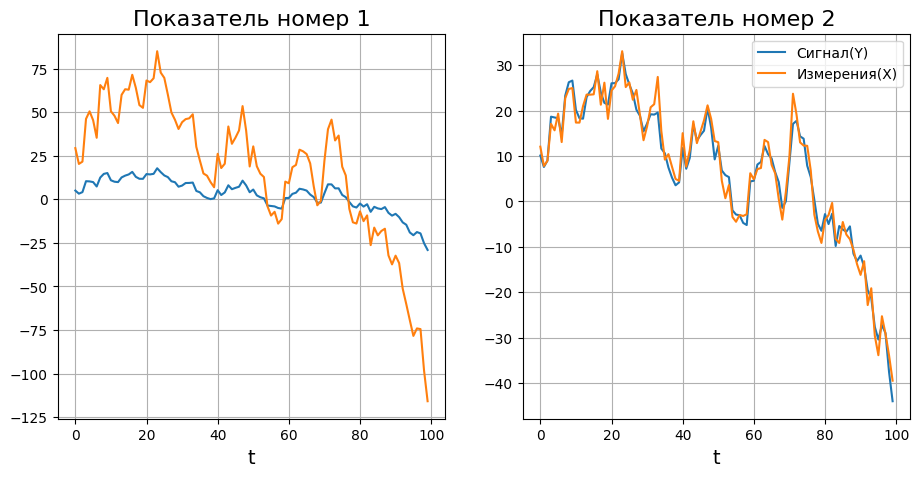

In [16]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(11,5))

ax1.grid()
ax1.set_title("Показатель номер 1", fontsize=16)
ax1.set_xlabel("t", fontsize=14)
ax1.plot(np.arange(T), ys[0,:])
ax1.plot(np.arange(T), xs[0,:])



ax2.grid()
ax2.set_title("Показатель номер 2", fontsize=16)
ax2.set_xlabel("t", fontsize=14)
ax2.plot(np.arange(T), ys[1,:])
ax2.plot(np.arange(T), xs[1,:])

ax2.legend(["Сигнал(Y)","Измерения(X)"])
# plt.savefig('filtered.pdf')
plt.show()



## Имплементируем фильтр Калмана

Теперь рализуем класс для фильтрации и сглаживания.

In [17]:
class KalmanFilter:

    def __init__(self,A,B,Ry,Rx,startMean=None, startCov=None):
        #dynamics
        self.A = A
        self.B = B
        
        #covariances
        self.Rx = Rx#measurements
        self.Ry = Ry#states
        
        #start mean and cov
        self.startMean = startMean
        if(startCov is None):
            self.startCov = np.eye(self.A.shape[0]) 
        else:
            self.startCov = startCov
            

    def filterStep(self,aprioriY0,aprioriErr0,obs):
        aprioriY = self.A@aprioriY0
        aprioriErr = self.A@(aprioriErr0@(self.A.T)) + self.Ry #new apriori error
        K = aprioriErr@(self.B.T)@np.linalg.inv(self.Rx + self.B@aprioriErr@(self.B.T))#?? #?? Kalman Gain
        aposterioriY = aprioriY + K@(obs - self.B@aprioriY) #aposteriori
        aposterioriErr = (np.eye(self.A.shape[0])-K@self.B)@aprioriErr #aposteriori error

        return aprioriY,aprioriErr,aposterioriY,aposterioriErr
    
    def filterSignal(self, signal):
        

        filteredSignal = np.zeros([self.A.shape[0],signal.shape[-1]])
        aprSignals = np.zeros([self.A.shape[0],signal.shape[-1]])
        errs = np.zeros([self.A.shape[0],self.A.shape[0],signal.shape[-1]])
        aprErrs = np.zeros([self.A.shape[0],self.A.shape[0],signal.shape[-1]])
        filteredSignal[:,0] = signal[:,0]

        aprSig0 = filteredSignal[:,0]
        aprErr0 = self.startCov
        errs[:,:,0] = self.startCov

        for i in np.arange(1,signal.shape[1]):
            aprSig,aprErr,apostSig,apostErr = self.filterStep(aprSig0,aprErr0,signal[:,i])
            aprSig0 = aprSig
            aprErr0 = aprErr
            
            filteredSignal[:,i] = apostSig
            errs[:,:,i] = apostErr
            aprSignals[:,i] = aprSig
            aprErrs[:,:,i] = aprErr

        return filteredSignal, errs, aprSignals, aprErrs
    
    def smoothSignal(self, filteredSignal, errs, aprSignal, aprErrs):
        
        #init est
        smoothedSignal = np.zeros_like(filteredSignal)
        smoothedSignal [...,-1] = filteredSignal[...,-1]
        
        #init cov
        smooothedErrs = np.zeros_like(errs)
        smooothedErrs[...,-1] = errs[...,-1]

        for t in np.arange(errs.shape[-1]-2,-1,-1):
            
            smoothingGain =  errs[...,t]@(np.transpose(self.A))@np.linalg.inv(aprErrs[...,t+1]) # gain
            smoothedSignal[...,t] = filteredSignal[...,t] + smoothingGain@(smoothedSignal[...,t+1]-aprSignal[...,t+1]) #?? # signal
            smooothedErrs[...,t] = errs[...,t] + \
                smoothingGain@(smooothedErrs[...,t+1] - aprErrs[...,t+1])@np.transpose(smoothingGain)#?? #covariance
                
        return smoothedSignal, smooothedErrs

Проверим, как фильтр справляется с произвольной задачей. Сгенерируем мир и наблюдения и проверим, как хорошо фильтр уточнит координаты.

In [18]:
A = np.eye(2)
B = np.array([[1.9999,0.31],[-0.2,1.911]])
Ry = np.array([[2,0.00002],[0.00002,3]])*10
Rx = np.array([[1.3,0.0002],[0.0002,3]])*10
T=100

sigGen = LinearGaussianSignalGenerator(A, B, Ry, Rx)

startMean=np.array([10,5])
startCov=np.eye(2)*0.1

In [19]:
start = np.random.multivariate_normal(mean=startMean,cov=startCov)#np.array([10,5])
ys, xs = sigGen.generate(T,start)

In [20]:
filter = KalmanFilter(A, B, Ry, Rx,startMean,startCov)
sig,errs,aprSig,aprErrs = filter.filterSignal(xs)
smoothedSig, smoothedErrs = filter.smoothSignal(sig,errs,aprSig,aprErrs)

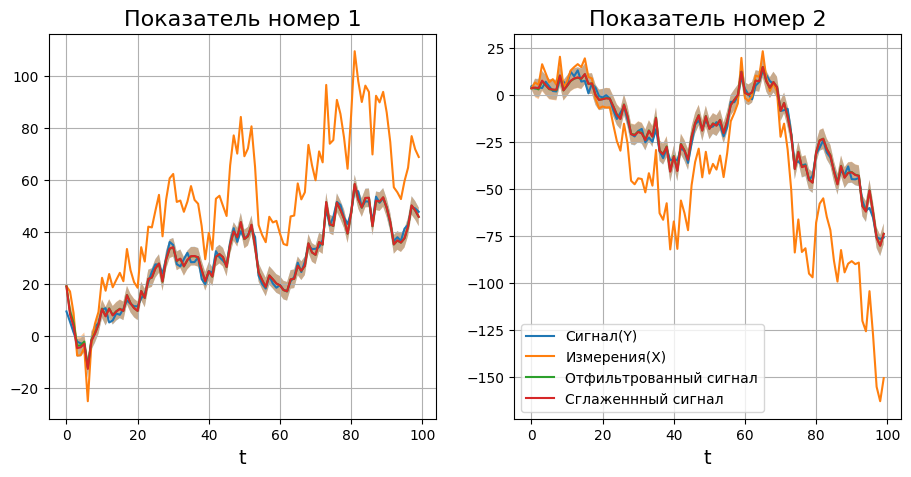

In [21]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(11,5))

ax1.grid()
ax1.set_title("Показатель номер 1", fontsize=16)
ax1.set_xlabel("t", fontsize=14)
ax1.plot(np.arange(T), ys[0,:])
ax1.plot(np.arange(T), xs[0,:])
ax1.plot(np.arange(T), sig[0,:])
ax1.plot(np.arange(T), smoothedSig[0,:])
ax1.fill_between(np.arange(T),smoothedSig[0,:]-1.96*np.sqrt(smoothedErrs[0,0,:]), smoothedSig[0,:]+1.96*np.sqrt(smoothedErrs[0,0,:]), alpha=0.4 )
ax1.fill_between(np.arange(T),sig[0,:]-1.96*np.sqrt(errs[0,0,:]), sig[0,:]+1.96*np.sqrt(errs[0,0,:]), alpha=0.4 )


ax2.grid()
ax2.set_title("Показатель номер 2", fontsize=16)
ax2.set_xlabel("t", fontsize=14)
ax2.plot(np.arange(T), ys[1,:])
ax2.plot(np.arange(T), xs[1,:])
ax2.plot(np.arange(T), sig[1,:])
ax2.plot(np.arange(T), smoothedSig[1,:])
ax2.fill_between(np.arange(T),smoothedSig[1,:]-1.96*np.sqrt(smoothedErrs[1,1,:]), smoothedSig[1,:]+1.96*np.sqrt(smoothedErrs[1,1,:]), alpha=0.4 )
ax2.fill_between(np.arange(T),sig[1,:]-1.96*np.sqrt(errs[1,1,:]), sig[1,:]+1.96*np.sqrt(errs[1,1,:]), alpha=0.4 )

ax2.legend(["Сигнал(Y)","Измерения(X)","Отфильтрованный сигнал","Сглаженнный сигнал"])
# plt.savefig('filtered.pdf')
plt.show()

При известных параметрах фильтр справляется со своей задачей очень хорошо. 

## Оценка скорости движения и погрешности

Давайте попробуем немного усложнить сеттинг и сказать, что наблюдение неполное. Предположим, мы отслеживаем велосипед, который движется (почти) равномерно по прямой. Наша задача -- уточнить шумные наблюдения и оценить скорость в каждой точке наблюдений.

Модель мира выглядит так:

$$
Y_{t+1} = A Y_t + U_t, ~A = \begin{bmatrix}1 & \Delta t\\ 0 & 1 \end{bmatrix}.
$$

Мир описывается положением велосипеда (первая координата) и скоростью (вторая координата).

Наблюдаем мы только координату (по условному одномерному GPS):

$$
X_{t+1} = B Y_{t+1} + V_{t+1}, ~ B = [1,0] .
$$

Для определённости возьмём единичные матрицы в качестве дисперсий шумов, а стартовое состояние зададим с большей дисперсией.


In [41]:
deltaT = 0.1
A = np.eye(2)
A[0,1] = deltaT
A[1,1] = 1

B=np.array([[1,0.2],[0,0.9]])

Ry = np.eye(2)
Rx = np.eye(2)*5

T=100

sigGen = LinearGaussianSignalGenerator(A, B, Ry, Rx)

startMean=np.array([0,10])
startCov=np.eye(2)*10

start = np.random.multivariate_normal(mean=startMean,cov=startCov)#np.array([10,5])
ys, xs = sigGen.generate(T,start)

filter = KalmanFilter(A, B, Ry, Rx,startMean,startCov)

In [42]:
sig,errs,aprSig,aprErrs = filter.filterSignal(xs)
smoothedSig, smoothedErrs = filter.smoothSignal(sig,errs,aprSig,aprErrs)

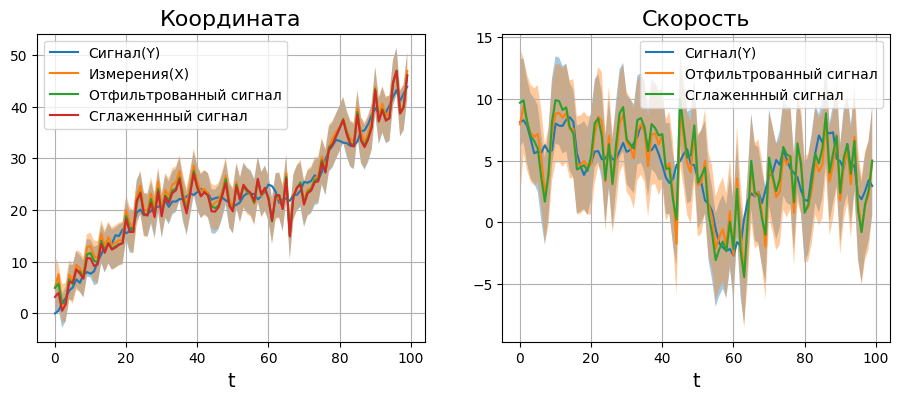

In [43]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(11,4))

ax1.grid()
ax1.set_title("Координата", fontsize=16)
ax1.set_xlabel("t", fontsize=14)
ax1.plot(np.arange(T), ys[0,:])
ax1.plot(np.arange(T), xs[0,:])
ax1.plot(np.arange(T), sig[0,:])
ax1.plot(np.arange(T), smoothedSig[0,:])
ax1.fill_between(np.arange(T),smoothedSig[0,:]-1.96*np.sqrt(smoothedErrs[0,0,:]), smoothedSig[0,:]+1.96*np.sqrt(smoothedErrs[0,0,:]), alpha=0.4 )
ax1.fill_between(np.arange(T),sig[0,:]-1.96*np.sqrt(errs[0,0,:]), sig[0,:]+1.96*np.sqrt(errs[0,0,:]), alpha=0.4 )
ax1.legend(["Сигнал(Y)", "Измерения(X)","Отфильтрованный сигнал","Сглаженнный сигнал"])


ax2.grid()
ax2.set_title("Скорость", fontsize=16)
ax2.set_xlabel("t", fontsize=14)
ax2.plot(np.arange(T), ys[1,:])
#ax2.plot(np.arange(T), xs[1,:])
ax2.plot(np.arange(T), sig[1,:])
ax2.plot(np.arange(T), smoothedSig[1,:])
ax2.fill_between(np.arange(T),smoothedSig[1,:]-1.96*np.sqrt(smoothedErrs[1,1,:]), smoothedSig[1,:]+1.96*np.sqrt(smoothedErrs[1,1,:]), alpha=0.4 )
ax2.fill_between(np.arange(T),sig[1,:]-1.96*np.sqrt(errs[1,1,:]), sig[1,:]+1.96*np.sqrt(errs[1,1,:]), alpha=0.4 )

ax2.legend(["Сигнал(Y)","Отфильтрованный сигнал","Сглаженнный сигнал"])
# plt.savefig('filtered.pdf')
plt.show()

Координата и так хорошо оценивается, но у нас раньше не было никакой информации о скорости, а теперь мы её оценили. Это подход гораздо более устойчивый, чем с помощью численного дифференцирования.